# Setup

In [20]:
# Imports

from PIL import Image
import numpy as np
import json

from torchvision.transforms import ToTensor, ToPILImage
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
import torch

from captum.attr import visualization as vis
from captum.attr import Saliency, GuidedBackprop, Occlusion, IntegratedGradients
from matplotlib import pyplot as plt

### Train Model

In [25]:
# Prepare training and test data
training_data = datasets.FashionMNIST( root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(training_data, batch_size=128)
test_data_loader = DataLoader(test_data, batch_size=128)

In [18]:
fashion_labels = {0: 'T-Shirt',
                  1: 'Trowser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle Boot'}

In [21]:
# Define network
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
 
    def forward(self, x):
        return self.conv_stack(x)

In [22]:
def train_loop(data_loader, model, loss_function, optimizer):
    mean_loss, n_correct = 0, 0

    for batch, (data, labels) in enumerate(data_loader):
        # Feed data through network and compute loss.
        prediction = model(data)
        loss = loss_function(prediction, labels)
 
        # Zero gradients.
        optimizer.zero_grad()
 
        # Perform backpropagation and accumulate gradients.
        loss.backward()
 
        # Update network parameters.
        optimizer.step()

        mean_loss += loss.detach().item()
        n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

def test_loop(data_loader, model, loss_function):
    mean_loss, n_correct = 0, 0
 
    with torch.no_grad():
        for data, labels in data_loader:
            # Feed data through network and accumulate loss.
            prediction = model(data)
            
            mean_loss += loss_function(prediction, labels).item()
            n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
 
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

In [23]:
model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

In [26]:
for epoch in range(n_epochs):
    print(f' Epoch {epoch+1:02}: ', end='\t')
    train_acc, train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    print(f'Train Accuracy: {train_acc:.2%},', f'Train Loss: {train_loss:.4}', end=',\t')
    test_acc, test_loss = test_loop(test_data_loader, model, loss_fn)
    print(f'Test Accuracy: {test_acc:.2%},', f'Test Loss: {test_loss:.4}')
model.eval();

 Epoch 01: 	Train Accuracy: 71.75%, Train Loss: 0.7597,	Test Accuracy: 78.87%, Test Loss: 0.5778
 Epoch 02: 	Train Accuracy: 81.58%, Train Loss: 0.5013,	Test Accuracy: 82.07%, Test Loss: 0.489
 Epoch 03: 	Train Accuracy: 84.29%, Train Loss: 0.4359,	Test Accuracy: 83.87%, Test Loss: 0.4439
 Epoch 04: 	Train Accuracy: 85.87%, Train Loss: 0.3935,	Test Accuracy: 85.18%, Test Loss: 0.4094
 Epoch 05: 	Train Accuracy: 86.73%, Train Loss: 0.3655,	Test Accuracy: 85.74%, Test Loss: 0.3939


In [27]:
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False

# Task 1

Real Label:       Trowser
Predicted Label:  Trowser


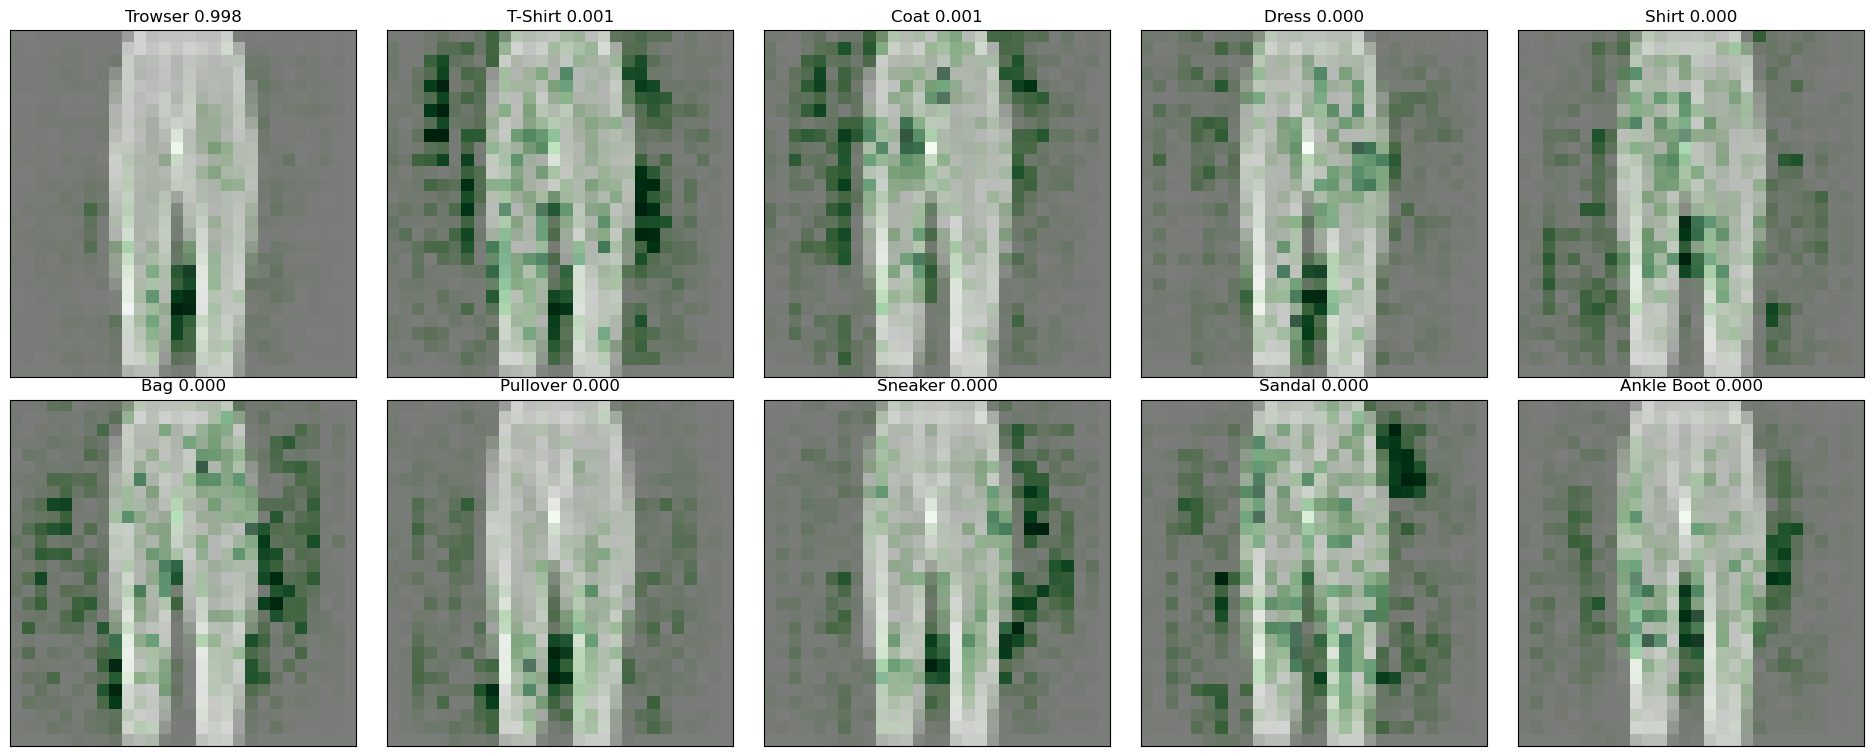

In [103]:
IMG_NR = 13009

image, label = training_data[IMG_NR]
tensor = image.view(1, 1, 28, 28)
prediction = model(tensor).argmax().item()

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[prediction])

predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
top_values, top_idx = torch.topk(values, 10)

#guided = GuidedBackprop(model)
#occlusion = Occlusion(model)
saliency = Saliency(model)

figure, axes = plt.subplots(2, 5, figsize=(5 * 3.8, 2 * 3.8))

for axis, i, v in zip(axes.flatten(), top_idx.cpu().squeeze(), top_values.cpu().squeeze()):
    attribution = saliency.attribute(tensor, target=int(i)).numpy().squeeze()#, **{"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)}).numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(fashion_labels[i.item()].split(",")[0] + f" {v:0.3f}")

plt.tight_layout()
#figure.savefig("different_targets.png", bbox_inches="tight")

Real Label:       Sneaker
Predicted Label:  Sneaker


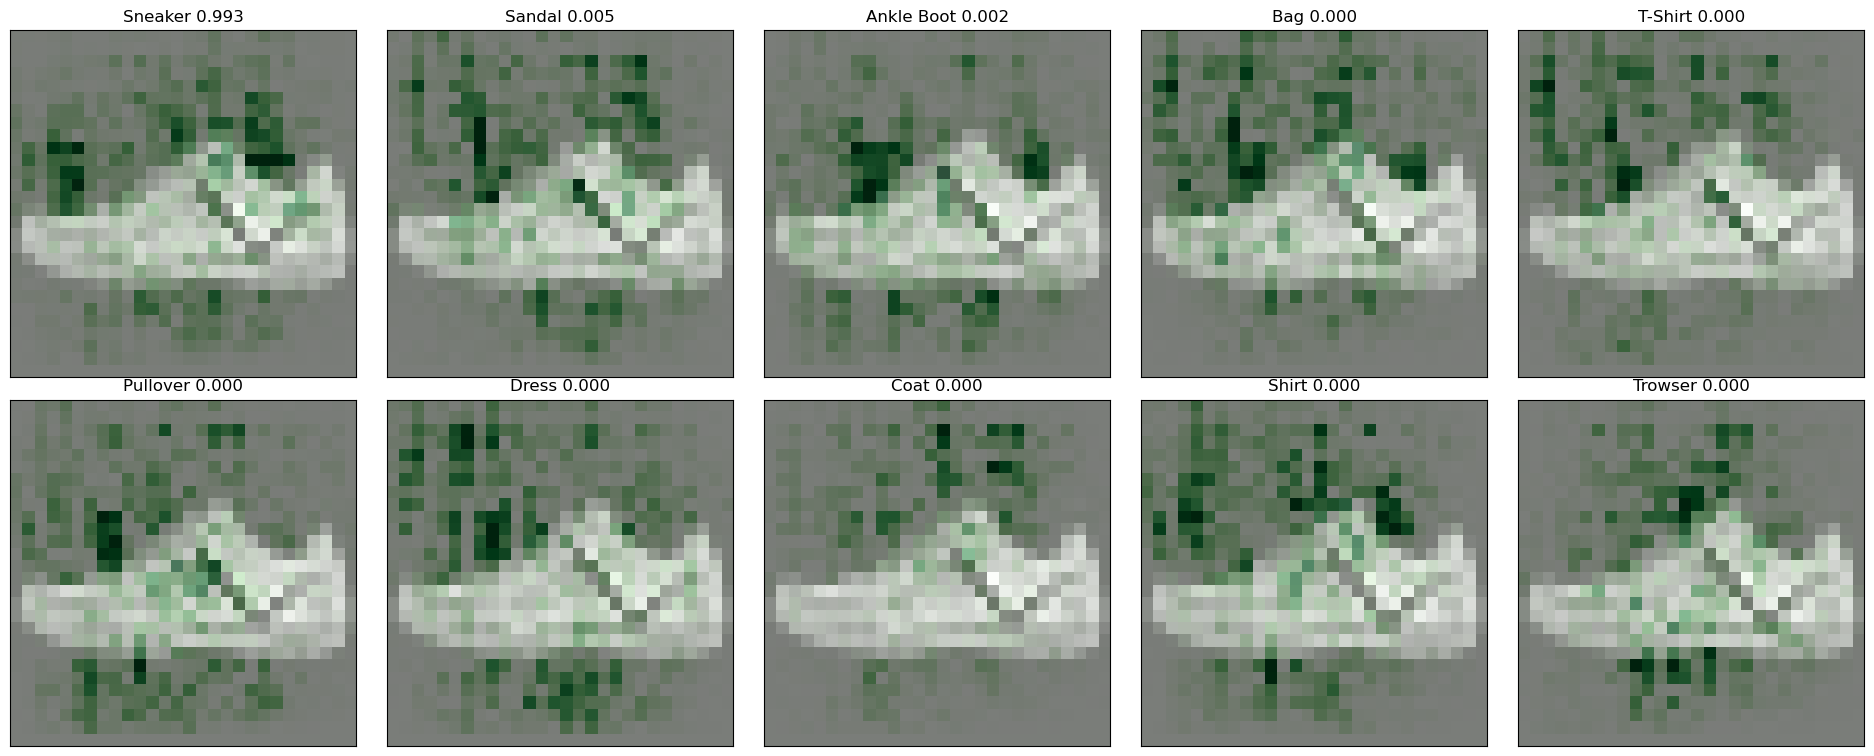

In [104]:
IMG_NR = 5571

image, label = training_data[IMG_NR]
tensor = image.view(1, 1, 28, 28)
prediction = model(tensor).argmax().item()

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[prediction])

predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
top_values, top_idx = torch.topk(values, 10)

#guided = GuidedBackprop(model)
#occlusion = Occlusion(model)
saliency = Saliency(model)

figure, axes = plt.subplots(2, 5, figsize=(5 * 3.8, 2 * 3.8))

for axis, i, v in zip(axes.flatten(), top_idx.cpu().squeeze(), top_values.cpu().squeeze()):
    attribution = saliency.attribute(tensor, target=int(i)).numpy().squeeze()#, **{"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)}).numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(fashion_labels[i.item()].split(",")[0] + f" {v:0.3f}")

plt.tight_layout()
#figure.savefig("different_targets.png", bbox_inches="tight")

Real Label:       Bag
Predicted Label:  Bag


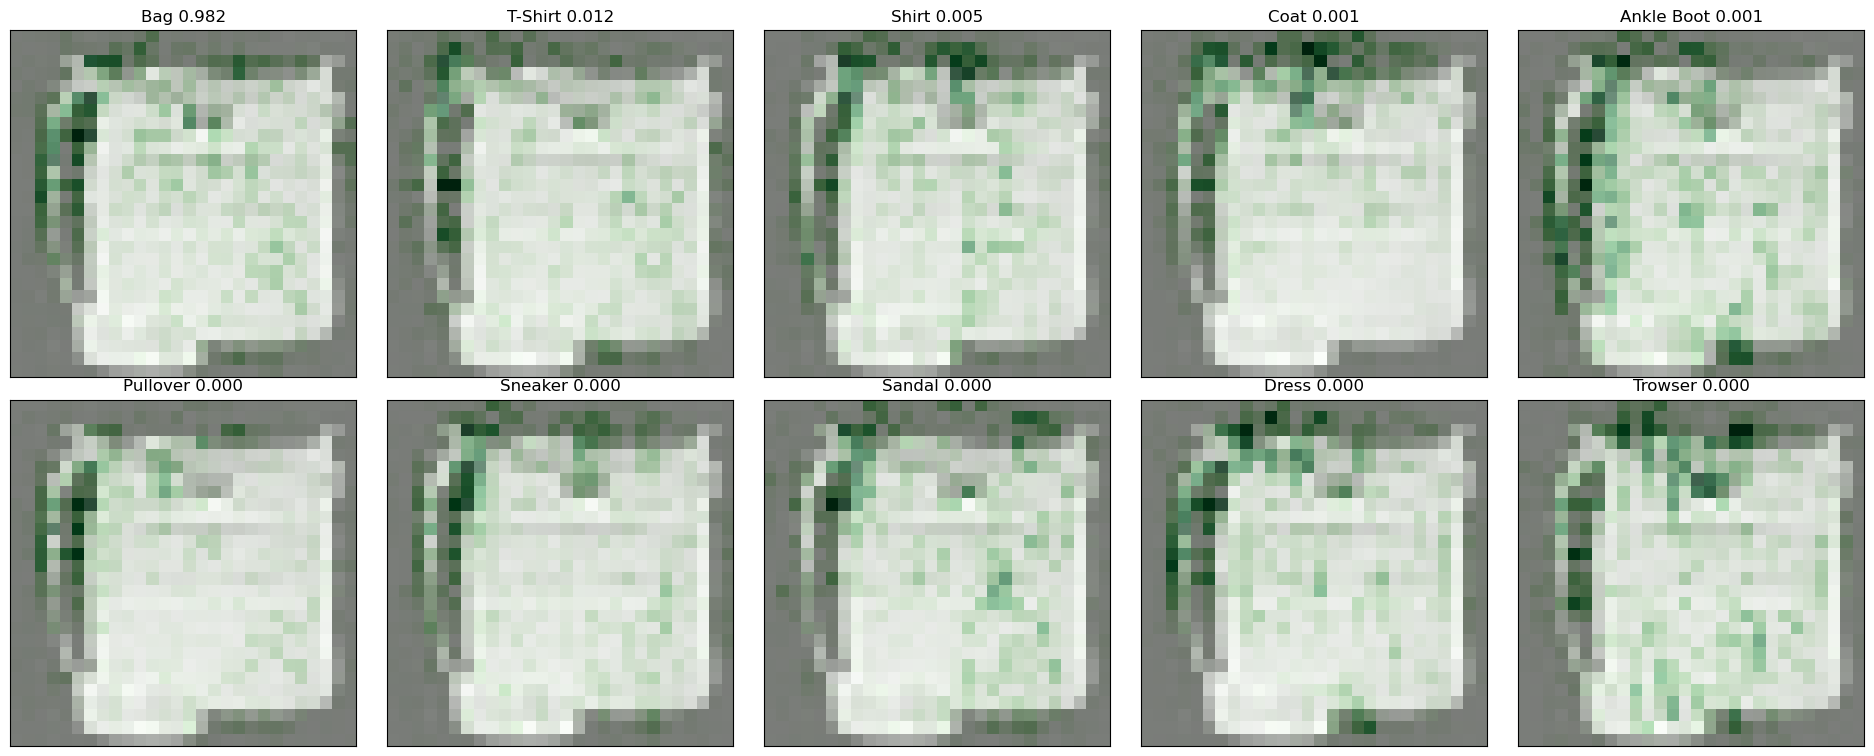

In [106]:
IMG_NR = 46626

image, label = training_data[IMG_NR]
tensor = image.view(1, 1, 28, 28)
prediction = model(tensor).argmax().item()

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[prediction])

predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
top_values, top_idx = torch.topk(values, 10)

#guided = GuidedBackprop(model)
#occlusion = Occlusion(model)
saliency = Saliency(model)

figure, axes = plt.subplots(2, 5, figsize=(5 * 3.8, 2 * 3.8))

for axis, i, v in zip(axes.flatten(), top_idx.cpu().squeeze(), top_values.cpu().squeeze()):
    attribution = saliency.attribute(tensor, target=int(i)).numpy().squeeze()#, **{"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)}).numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(fashion_labels[i.item()].split(",")[0] + f" {v:0.3f}")

plt.tight_layout()
#figure.savefig("different_targets.png", bbox_inches="tight")

Real Label:       Dress
Predicted Label:  Dress


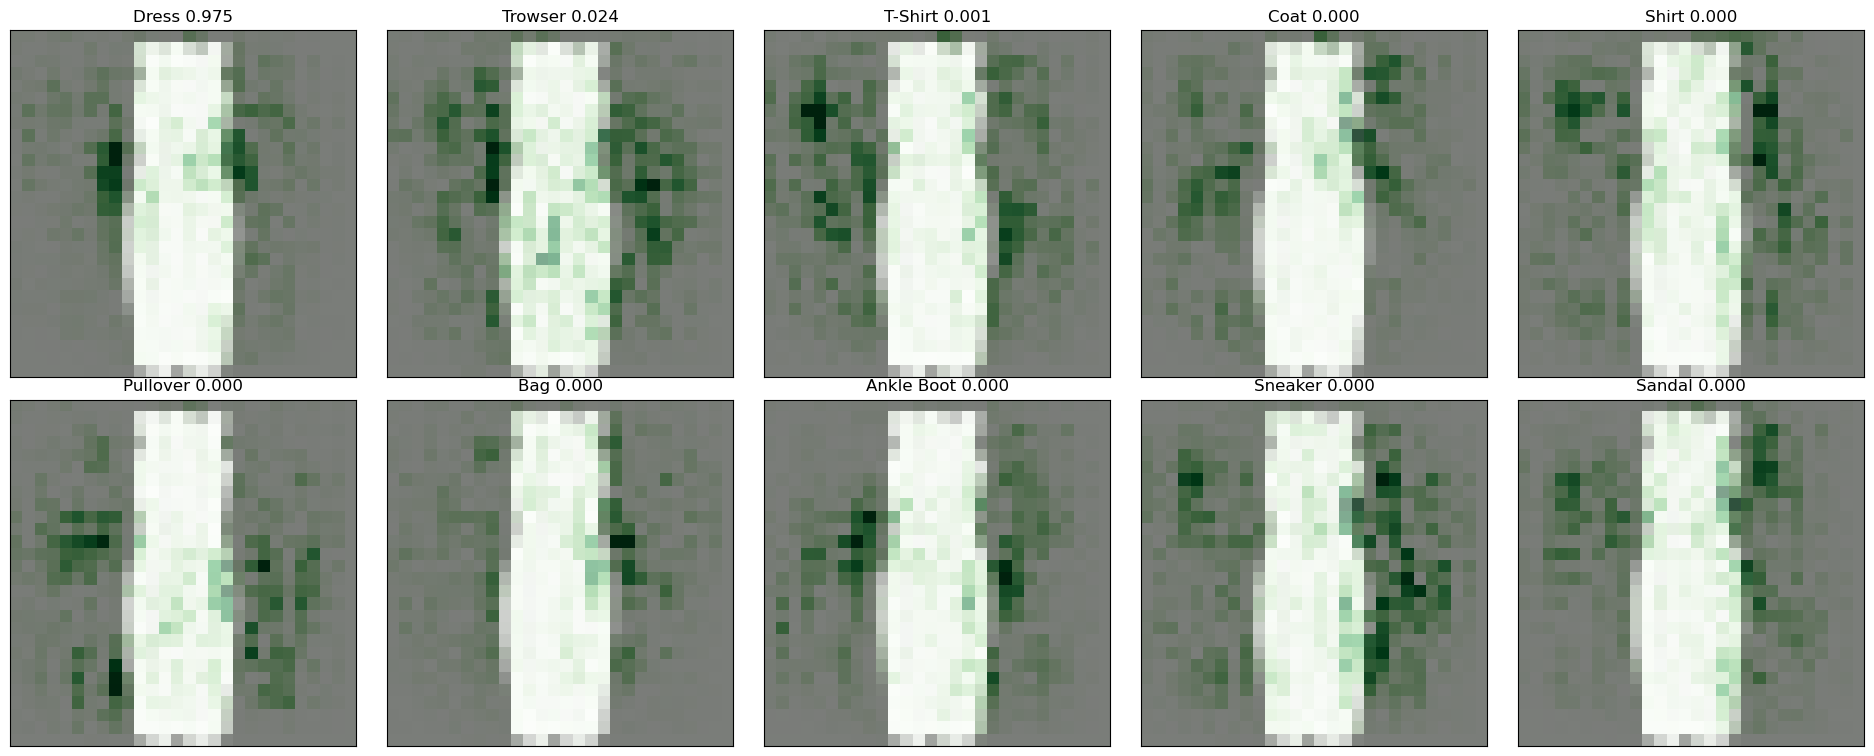

In [108]:
IMG_NR = 38082

image, label = training_data[IMG_NR]
tensor = image.view(1, 1, 28, 28)
prediction = model(tensor).argmax().item()

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[prediction])

predictions = model(tensor).squeeze()
values = torch.softmax(predictions, 0)
top_values, top_idx = torch.topk(values, 10)

#guided = GuidedBackprop(model)
#occlusion = Occlusion(model)
saliency = Saliency(model)

figure, axes = plt.subplots(2, 5, figsize=(5 * 3.8, 2 * 3.8))

for axis, i, v in zip(axes.flatten(), top_idx.cpu().squeeze(), top_values.cpu().squeeze()):
    attribution = saliency.attribute(tensor, target=int(i)).numpy().squeeze()#, **{"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)}).numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(fashion_labels[i.item()].split(",")[0] + f" {v:0.3f}")

plt.tight_layout()
#figure.savefig("different_targets.png", bbox_inches="tight")

# Task 2

Real Label:       Bag
Predicted Label:  Bag


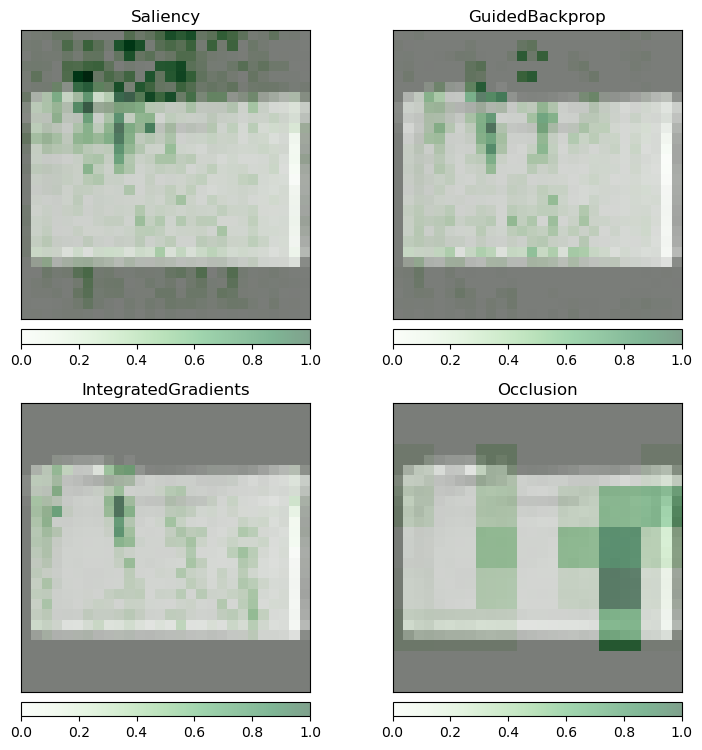

In [114]:
IMG_NR = 1234

image, label = training_data[IMG_NR]
tensor = image.view(1, 1, 28, 28)
prediction = model(tensor).argmax().item()

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[prediction])

# Compute and visualize attributions
methods = [
    (Saliency(model), {}),
    (GuidedBackprop(model), {}),
    (IntegratedGradients(model), {}),
    (Occlusion(model), {"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)})
]

figure, axes = plt.subplots(2, 2, figsize=(2 * 3.8, 2 * 3.8))
 
for axis, (method, params) in zip(axes.flatten(), methods):
    tensor_clone = torch.clone(tensor)
    attribution = method.attribute(tensor_clone, target=prediction, **params)
    attribution = torch.clone(attribution).cpu().detach().numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        show_colorbar=True,
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(type(method).__name__)
 
plt.tight_layout()
figure.savefig("methods.png", bbox_inches="tight")

In [115]:
# Prepare input image
modified_tensor = tensor.requires_grad_()

# Pass input through network
prediction_tensor = model(modified_tensor)

# Prepare target
original_label = prediction_tensor[0].argmax().item()
target_tensor = torch.tensor([original_label], dtype=torch.long)

# Loss
loss = torch.nn.CrossEntropyLoss()
loss_value = loss(prediction_tensor, target_tensor)

# Zero gradients
model.zero_grad()
modified_tensor.grad = None

# Propagate error backwards through the network
loss_value.backward()

In [116]:
# Modify input

attack_scale = 0.5 * 0.5
new_label = original_label
while new_label == original_label:
    print('#', end='')
    attack_scale *= 2.0
    modified_tensor.data += attack_scale * modified_tensor.grad.data

    # Clamp modified input such that it corresponds to an image
    modified_tensor.data[:, 0, :, :].clamp_(-0.485 / 0.229, (1 - 0.485) / 0.229)

    # Pass modified input through network and determine 'winning' label
    prediction_tensor = model(modified_tensor)[0]
    new_label = prediction_tensor.argmax().item()

###########

Predicted Label:  Coat


/home/julian/anaconda3/envs/deep/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


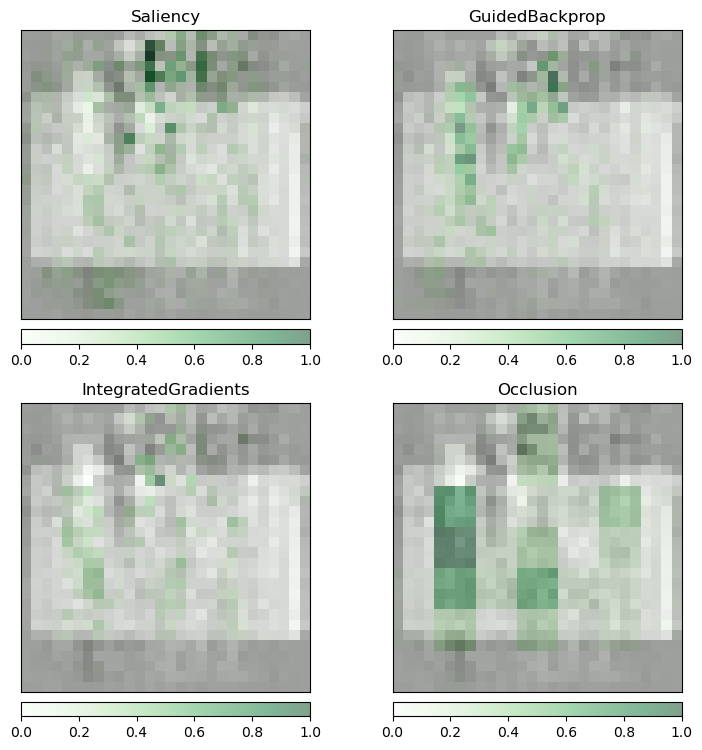

In [124]:
prediction = model(tensor).argmax().item()
print('Predicted Label: ', fashion_labels[prediction])

# Compute and visualize attributions
methods = [
    (Saliency(model), {}),
    (GuidedBackprop(model), {}),
    (IntegratedGradients(model), {}),
    (Occlusion(model), {"sliding_window_shapes": (1, 4, 4), "strides": (1, 4, 4)})
]

figure, axes = plt.subplots(2, 2, figsize=(2 * 3.8, 2 * 3.8))
 
for axis, (method, params) in zip(axes.flatten(), methods):
    tensor_clone = torch.clone(tensor)
    attribution = method.attribute(tensor_clone, target=prediction, **params)
    attribution = torch.clone(attribution).cpu().detach().numpy().squeeze()
    vis.visualize_image_attr(
        attribution.reshape(28, 28, 1),
        original_image=image.numpy().reshape(28, 28, 1),
        method="blended_heat_map",
        sign="positive",
        show_colorbar=True,
        plt_fig_axis=(figure, axis),
        use_pyplot=False,
    )
    axis.set_title(type(method).__name__)
 
plt.tight_layout()
figure.savefig("methods.png", bbox_inches="tight")